# SSD300 Training for Plant Disease 



In [1]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt
import requests 

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline


print("done")

Using TensorFlow backend.


done


## 1. Set the model configuration parameters



In [2]:
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from keras import optimizers, models
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras import applications
from keras import backend as K
import tensorflow as tf
import os

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [0, 1, 2] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 31 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 256] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = True # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

print("done")




done


## 2. Build or load the model



### 2.1 Create a new model and load trained VGG-16 weights into it (or trained SSD weights)

If you want to create a new SSD300 model, this is the relevant section for you. If you want to load a previously saved SSD300 model, skip ahead to section 2.2.


In [3]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.
NUM_PARALLEL_EXEC_UNITS = 32

#Set Performance Parameters for MKL and Tensorflow using Keras backend
#TensorFlow
config = tf.ConfigProto(
    intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
    inter_op_parallelism_threads=1
)

session = tf.Session(config=config)
K.set_session(session)

#MKL and OpenMP
os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

model = ssd_300(image_size=(300, 300, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

#print("downloading model VGG_ILSVRC_16_layers_fc_reduced ...")
model_url = "http://iisl.co.in/system/InstantLeafDetect/ssd_model/VGG_ILSVRC_16_layers_fc_reduced.h5"
#r = requests.get(model_url) # create HTTP response object 
#with open("VGG_ILSVRC_16_layers_fc_reduced.h5",'wb') as f: 
#   f.write(r.content) 

print("done")    

# TODO: Set the path to the weights you want to load.
weights_path = 'VGG_ILSVRC_16_layers_fc_reduced.h5'
#weights_path = "ssd300_10leaf_detect_ver1.h5"

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
done
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_channel_swap (Lambda)     (No

### 2.2 Load a previously created model

If you have previously created and saved a model and would now like to load it, execute the next code cell. The only thing you need to do here is to set the path to the saved model HDF5 file that you would like to load.


In [ ]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
#model_path = 'path/to/trained/model.h5'

#model_path = "newly_created.vgg16.hdf5"
model_path = "ssd300_10leaf_detect_ver1.h5"

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

model.summary()

## 3. Set up the data generators for the training



In [4]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

VOC_2019_images_dir      = '/hdd/data/LeafDetectData/LEAF2019/JPEGImages/'

VOC_2019_annotations_dir      = '/hdd/data/LeafDetectData/LEAF2019/Annotations/'

VOC_2019_trainval_image_set_filename = '/hdd/data/LeafDetectData/LEAF2019/ImageSets/Main/trainval.txt'

VOC_2019_test_image_set_filename     = '/hdd/data/LeafDetectData/LEAF2019/ImageSets/Main/test.txt'

#classes = ['background','Potato_healthy','Potato_Early_blight','Infected_Potato_Early_blight',
#           'Potato_Late_blight','Infected_Potato_Late_blight','Tomato_healthy',
#           'Tomato_Early_blight','Infected_Tomato_Early_blight','Tomato_Late_blight','Infected_Tomato_Late_blight']


classes = [ 'background',
            'Potato_healthy',
            'Infected_Potato_Early_blight',
            'Potato_Early_blight',
            'Infected_Potato_Late_blight',
            'Potato_Late_blight',
            'Tomato_healthy',
            'Infected_Tomato_Septoria_spot',
            'Tomato_Septoria_spot',
            'Infected_Tomato_Spider_mites',
            'Tomato_Spider_mites',
            'Infected_Tomato_Target_Spot',
            'Tomato_Target_Spot',
            'Infected_Tomato_Curl_Virus',
            'Tomato_Curl_Virus',
            'Infected_Tomato_mosaic_virus',
            'Tomato_mosaic_virus',
            'Infected_Tomato_Leaf_Mold',
            'Tomato_Leaf_Mold',
            'Infected_Tomato_Bacterial_spot',
            'Tomato_Bacterial_spot',
            'Infected_Tomato_Early_blight',
            'Tomato_Early_blight',
            'Infected_Tomato_Late_blight',
            'Tomato_Late_blight',
            'Corn_healthy',
            'Infected_Corn_Common_rust',
            'Corn_Common_rust',
            'Infected_Corn_Gray_leaf',
            'Corn_Gray_leaf',
            'Infected_Corn_Northern_Blight',
            'Corn_Northern_Blight'
    
]

train_dataset.parse_xml(images_dirs=[VOC_2019_images_dir],
                        image_set_filenames=[VOC_2019_trainval_image_set_filename],
                        annotations_dirs=[VOC_2019_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[VOC_2019_images_dir],
                      image_set_filenames=[VOC_2019_test_image_set_filename],
                      annotations_dirs=[VOC_2019_annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

train_dataset.create_hdf5_dataset(file_path='dataset_31leaf_2019_trainval.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='dataset_31leaf_2019_test.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)

print("done")

Creating HDF5 dataset: 100%|██████████| 88/88 [00:00<00:00, 231.74it/s]
done


In [5]:
# 3: Set the batch size.

batch_size = 16 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  2136
Number of images in the validation dataset:	    88


## 4. Set the remaining training parameters



In [6]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [7]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='ssd300_31leaf_detect_epoch-{epoch:02d}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 7.5105

csv_logger = CSVLogger(filename='ssd300_31leaf_detect_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

## 5. Train

In [8]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 120   #120
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/120

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 8897s 9s/step - loss: 8.0991 - val_loss: 6.8569

Epoch 00001: val_loss improved from inf to 6.85686, saving model to ssd300_31leaf_detect_epoch-01.h5
Epoch 2/120

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
  56/1000 [>.............................] - ETA: 2:23:30 - loss: 6.2738

KeyboardInterrupt: 

## 6. Make predictions

Now let's make some predictions on the validation dataset with the trained model. For convenience we'll use the validation generator that we've already set up above. Feel free to change the batch size.

You can set the `shuffle` option to `False` if you would like to check the model's progress on the same image(s) over the course of the training.

In [9]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [10]:
# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: /hdd/data/LeafDetectData/LEAF2019/JPEGImages/Potato_Early_blight_masked_27486.jpg

Ground truth boxes:

[[  2  21  15 239 247]
 [  3  26 140  75 199]
 [  3 103  82 166 147]
 [  3 176  75 234 148]
 [  3  94 180 142 232]
 [  3 106  40 164  75]]


In [11]:
# 3: Make predictions.

y_pred = model.predict(batch_images)

Now let's decode the raw predictions in `y_pred`.



In [12]:
# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

In [13]:
# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  2.     0.53  37.    13.   242.   237.  ]]


Finally, let's draw the predicted boxes onto the image. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

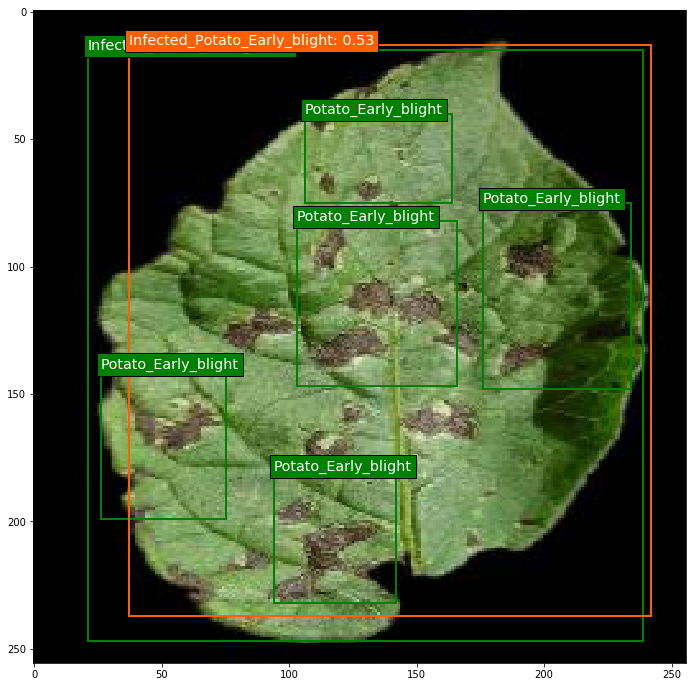

In [14]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()

#classes = ['background','Potato_healthy','Potato_Early_blight','Infected_Potato_Early_blight',
#           'Potato_Late_blight','Infected_Potato_Late_blight','Tomato_healthy',
#           'Tomato_Early_blight','Infected_Tomato_Early_blight','Tomato_Late_blight','Infected_Tomato_Late_blight']

classes = [ 'background',
            'Potato_healthy',
            'Infected_Potato_Early_blight',
            'Potato_Early_blight',
            'Infected_Potato_Late_blight',
            'Potato_Late_blight',
            'Tomato_healthy',
            'Infected_Tomato_Septoria_spot',
            'Tomato_Septoria_spot',
            'Infected_Tomato_Spider_mites',
            'Tomato_Spider_mites',
            'Infected_Tomato_Target_Spot',
            'Tomato_Target_Spot',
            'Infected_Tomato_Curl_Virus',
            'Tomato_Curl_Virus',
            'Infected_Tomato_mosaic_virus',
            'Tomato_mosaic_virus',
            'Infected_Tomato_Leaf_Mold',
            'Tomato_Leaf_Mold',
            'Infected_Tomato_Bacterial_spot',
            'Tomato_Bacterial_spot',
            'Infected_Tomato_Early_blight',
            'Tomato_Early_blight',
            'Infected_Tomato_Late_blight',
            'Tomato_Late_blight',
            'Corn_healthy',
            'Infected_Corn_Common_rust',
            'Corn_Common_rust',
            'Infected_Corn_Gray_leaf',
            'Corn_Gray_leaf',
            'Infected_Corn_Northern_Blight',
            'Corn_Northern_Blight'
    
]

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})